# CS 109A/STAT 121A/AC 209A/CSCI E-109A

## Standard Section 1: Introduction to Webscraping with BeautifulSoup 

**Harvard University**<br/>
**Fall 2017**<br/>
**Section Leaders: Albert Wu, Matthew Holman, Nathaniel Burbank <br/>**
**Instructors: Pavlos Protopapas, Kevin Rader, Rahul Dave, Margo Levine** 

Sometimes the most interesting data sets don’t come with an API or pre-packaged plain-text CSVs. In these situations, web scraping can be a powerful tool, enabling us to extract and convert data from almost any format found on the internet into a tabular form we can conduct further analysis on. 

For this section we will be working with historic population estimates of different US states listed on Wikipedia here:https://en.wikipedia.org/wiki/List_of_U.S._states_by_historical_population. In this section, you’ll learn how to import html-tables on the web into something you can manipulate with pandas. 

Specifically, we will: 
    
    1. Download the relevant webpage as raw html with the requests library  
    2. Parse the html into a tree-like python-object with the BeautifulSoup library
    3. Use BeautifulSoup to select and extract just the tables we’re interested in
    4. Combine the tables, clean the text, and convert them into a single python dictionary 
    5. Make a pandas dataframe from the dictionary 
    6. Doing some basic analysis and plotting (with matplotlib) 

As usual, our first step is to import the necessary libraries.

In [4]:
%matplotlib inline
import numpy as np
import scipy as sp
import matplotlib as mpl
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import pandas as pd
pd.set_option('display.width', 500)
pd.set_option('display.max_columns', 100)
pd.set_option('display.notebook_repr_html', True)
import seaborn as sns
sns.set_style("whitegrid")
sns.set_context("poster")

# Two new 
import requests 
requests.packages.urllib3.disable_warnings()
#Requests enables us to download raw html as text
from bs4 import BeautifulSoup 
# BeautifulSoup enables us to navigate html in python with dom-like tree structure 

## Step 1: Download the relevant webpage as raw html

In [5]:
url = "http://en.wikipedia.org/wiki/List_of_U.S._states_by_historical_population"
r = requests.get(url, timeout=20,verify=False)

Always remember to “not to be evil” when scraping with requests! If downloading multiple pages (like you will be on HW1), always put a delay between requests (e.g,, time.sleep(1), with the time library) so you don’t unwittingly hammer someone’s webserver and/or get blocked.

In [6]:
raw_html = r.text
raw_html

'<!DOCTYPE html>\n<html class="client-nojs" lang="en" dir="ltr">\n<head>\n<meta charset="UTF-8"/>\n<title>List of U.S. states by historical population - Wikipedia</title>\n<script>document.documentElement.className = document.documentElement.className.replace( /(^|\\s)client-nojs(\\s|$)/, "$1client-js$2" );</script>\n<script>(window.RLQ=window.RLQ||[]).push(function(){mw.config.set({"wgCanonicalNamespace":"","wgCanonicalSpecialPageName":false,"wgNamespaceNumber":0,"wgPageName":"List_of_U.S._states_by_historical_population","wgTitle":"List of U.S. states by historical population","wgCurRevisionId":792330334,"wgRevisionId":792330334,"wgArticleId":30259061,"wgIsArticle":true,"wgIsRedirect":false,"wgAction":"view","wgUserName":null,"wgUserGroups":["*"],"wgCategories":["Articles to be merged from April 2016","All articles to be merged","CS1 maint: BOT: original-url status unknown","Lists by population","Lists of states of the United States","United States demography-related lists"],"wgBreak

Now, we have all our data in the notebook. Unfortunately, it is the form of one really long string, which is hard to work with directly. This is where BeautifulSoup comes in.  

## Step 2: Parse the html with BeautifulSoup

In [11]:
soup = BeautifulSoup(raw_html, 'html.parser')
type(soup)

bs4.BeautifulSoup

Key BeautifulSoup functions we’ll be using in this section:
- **soup.prettify()**: Returns cleanedup version of raw html for printing
- **soup.find_all(<htmltag>,attrs=<attributes>)**: Returns python list of matching objects
- **soup.find(<htmltag>,attrs=<attributes>)**: Returns first matching object 
- **soup.text/soup.get_text()**: Returns visible text of an object (e.g.,"`<p>Some text</p>`" -> "Some text")
    
BeautifulSoup is a very powerful library -- much more info here: https://www.crummy.com/software/BeautifulSoup/bs4/doc/

### Let's practice some BeautifulSoup commands.. 

**Print a cleanedup version of raw html for printing**

In [13]:
# Your code here  
print(type(soup.prettify()))
print(soup.prettify()[:1000])

<class 'str'>
<!DOCTYPE html>
<html class="client-nojs" dir="ltr" lang="en">
 <head>
  <meta charset="utf-8"/>
  <title>
   List of U.S. states by historical population - Wikipedia
  </title>
  <script>
   document.documentElement.className = document.documentElement.className.replace( /(^|\s)client-nojs(\s|$)/, "$1client-js$2" );
  </script>
  <script>
   (window.RLQ=window.RLQ||[]).push(function(){mw.config.set({"wgCanonicalNamespace":"","wgCanonicalSpecialPageName":false,"wgNamespaceNumber":0,"wgPageName":"List_of_U.S._states_by_historical_population","wgTitle":"List of U.S. states by historical population","wgCurRevisionId":792330334,"wgRevisionId":792330334,"wgArticleId":30259061,"wgIsArticle":true,"wgIsRedirect":false,"wgAction":"view","wgUserName":null,"wgUserGroups":["*"],"wgCategories":["Articles to be merged from April 2016","All articles to be merged","CS1 maint: BOT: original-url status unknown","Lists by population","Lists of states of the United States","United States dem

** Find the first “title” object ** 

In [15]:
# Your code here
print(soup.find("title"))

<title>List of U.S. states by historical population - Wikipedia</title>


** Find the text of first “title” object ** 

In [16]:
# Your code here
print(soup.find("title").text)

List of U.S. states by historical population - Wikipedia


## Step 3: extract just the tables we’re interested in 

In [17]:
tables = soup.find_all("table",attrs={"class":"wikitable"})
# This says return a list of all table objects that include 
# the css class “wikitable” within the soup object.  
len(tables)

5

As it turns out, the data we’re interested in is in the 1st, 3rd, and 4th wikitable table on the page. 

In [18]:
tables = [tables[0], tables[2], tables[3]]
len(tables)

3

## Step 4: Convert the html tables into a python dictionary 

Before we can think about how to extract what we need, we need to understand how tables are constructed in HTML...

In [19]:
from IPython.core.display import display, HTML
display(HTML("""<table>
  <tr>
    <th>Firstname</th>
    <th>Lastname</th> 
    <th>Age</th>
  </tr>
  <tr>
    <td>Jill</td>
    <td>Smith</td> 
    <td>50</td>
  </tr>
  <tr>
    <td>Eve</td>
    <td>Jackson</td> 
    <td>94</td>
  </tr>
</table>"""))

Firstname,Lastname,Age
Jill,Smith,50
Eve,Jackson,94


Now let’s look at the first table in the list of tables we’re trying to import.

In [20]:
# Let's render the first table as HTML
from IPython.core.display import display, HTML
display(HTML(tables[0].prettify()))

Name,Admitted,1790,1800,1810,1820,1830,1840,1850,1860
Alabama,1819,,"1,250","9,046","127,901","309,527","590,756","771,623","964,201"
Alaska,1959,,,,,,,,
Arizona,1912,,,,,,,,
Arkansas,1836,,,"1,062","14,273","30,388","97,574","209,897","435,450"
California,1850,,,,,,,"92,597","379,994"
Colorado,1876,,,,,,,,"34,277"
Connecticut,1788,"237,946","251,002","262,042","275,202","297,675","309,978","370,792","460,147"
Delaware,1787,"59,096","64,273","72,674","72,749","76,748","78,085","91,532","112,216"
District of Columbia [1],,,"8,144","15,471","23,336","30,261","33,745","51,687","75,080"
Florida,1845,,,,,"34,730","54,477","87,445","140,424"


Our goal is to associate a series of population values with each state, so that we can build a time series table across all three tables. Things to keep in mind while building our extract routine:

    - We don’t care about the “admitted” column 
    - We want to remove the commas from the numbers so python interprets them as ints rather than strings 
    - We want to remove the footnotes and links 

Now, let’s try to extract out our data…

In [48]:
def rm_footnotes(s):
    """
    Removes any text after first '[' in string
    District of Columbia[1] -> District of Columbia"""
    # Your code here 
    return s.split("[")[0] # s[:s.find("[")]

def clean_int(s):
    """Removes any commas or footnotes from string and converts to int.
       Returns zero for blank strings"""
    # Your code here 
    # 100,000___ > 100000
    ret = rm_footnotes(s.strip().replace(',', ''))
    return int(ret) if ret else 0
    

In [51]:
d = dict()

for table in tables:
    """Extracts population data for states from all tables in tables 
      and store it in single dictionary d """
    
    headrow = table.find("tr")
    
    col_names = [(idx,th.text) for idx,th in enumerate(headrow.find_all('th')) if th.text.isnumeric()]
    # Makes list of tuples like this with idx and name for cols with years.
    # By using isnumeric, we only include columns are that are years. 
    # Result looks like this: 
    # [(2, '1790'), (3, '1800'), (4, '1810')]                     
    
    rows = table.find_all("tr")[1:]
    # List of rows in table excluding the header row 
    
    for row in rows:
        state_name = rm_footnotes(row.find('td').text)
        # String of state name, with any footnotes removed 
        
        all_cells = [c.text for c in row.find_all('td')]
        # List of cell values for row, e.g.: 
        # ['Alabama', '1819', '\xa0', '1,250', '9,046' .. ] 
        
        existing_values = d.get(state_name,{})
        # Existing dict of values for given state 
        
        new_values = {year:clean_int(all_cells[idx]) for (idx,year) in col_names}
        # For cols listed in col_names, return dict of cleaned int values 
        # {'1790': 0, '1800': 1250, '1810': 9046...}
        
        existing_values.update(new_values)
        # Merge with existing dict for state 
        d[state_name] = existing_values
d

{'Alabama': {'1790': 0,
  '1800': 1250,
  '1810': 9046,
  '1820': 127901,
  '1830': 309527,
  '1840': 590756,
  '1850': 771623,
  '1860': 964201,
  '1870': 996992,
  '1880': 1262505,
  '1890': 1513017,
  '1900': 1828697,
  '1910': 2138093,
  '1920': 2348174,
  '1930': 2646248,
  '1940': 2832961,
  '1950': 3061743,
  '1960': 3266740,
  '1970': 3444165,
  '1980': 3893888,
  '1990': 4040587,
  '2000': 4447100,
  '2010': 4779736},
 'Alaska': {'1790': 0,
  '1800': 0,
  '1810': 0,
  '1820': 0,
  '1830': 0,
  '1840': 0,
  '1850': 0,
  '1860': 0,
  '1870': 0,
  '1880': 0,
  '1890': 33426,
  '1900': 32052,
  '1910': 64356,
  '1920': 55036,
  '1930': 59278,
  '1940': 72524,
  '1950': 128643,
  '1960': 226167,
  '1970': 300382,
  '1980': 401851,
  '1990': 550043,
  '2000': 626932,
  '2010': 710231},
 'Arizona': {'1790': 0,
  '1800': 0,
  '1810': 0,
  '1820': 0,
  '1830': 0,
  '1840': 0,
  '1850': 0,
  '1860': 0,
  '1870': 9658,
  '1880': 40440,
  '1890': 88243,
  '1900': 122931,
  '1910': 204354,

## Step 5: Make a pandas dataframe from the dictionary 

Now that we have all three tables in a cleaned dictionary form, with each state as a key, and time series for each sate (as another dict) as it’s value, it's simple to convert to a pandas DataFrame.

In [56]:
df = pd.DataFrame.from_dict(d,orient='index')
df = df.reindex_axis(sorted(df.columns), axis=1)
df

,1790,1800,1810,1820,1830,1840,1850,1860,1870,1880,1890,1900,1910,1920,1930,1940,1950,1960,1970,1980,1990,2000,2010
Alabama,0,1250,9046,127901,309527,590756,771623,964201,996992,1262505,1513017,1828697,2138093,2348174,2646248,2832961,3061743,3266740,3444165,3893888,4040587,4447100,4779736
Alaska,0,0,0,0,0,0,0,0,0,0,33426,32052,64356,55036,59278,72524,128643,226167,300382,401851,550043,626932,710231
Arizona,0,0,0,0,0,0,0,0,9658,40440,88243,122931,204354,334162,435573,499261,749587,1302161,1770900,2718215,3665228,5130632,6392017
Arkansas,0,0,1062,14273,30388,97574,209897,435450,484471,802525,1128211,1311564,1574449,1752204,1854482,1949387,1909511,1786272,1923295,2286435,2350725,2673400,2915918
California,0,0,0,0,0,0,92597,379994,560247,864694,1213398,1485053,2377549,3426861,5677251,6907387,10586223,15717204,19953134,23667902,29760021,33871648,37253956
Colorado,0,0,0,0,0,0,0,34277,39864,194327,413249,539700,799024,939629,1035791,1123296,1325089,1753947,2207259,2889964,3294394,4301261,5029196
Connecticut,237946,251002,262042,275202,297675,309978,370792,460147,537454,622700,746258,908420,1114756,1380631,1606903,1709242,2007280,2535234,3031709,3107576,3287116,3405565,3574097
Delaware,59096,64273,72674,72749,76748,78085,91532,112216,125015,146608,168493,184735,202322,223003,238380,266505,318085,446292,548104,594338,666168,783600,897934
District of Columbia,0,8144,15471,23336,30261,33745,51687,75080,131700,177624,230392,278718,331069,437571,486869,663091,802178,763956,756510,638333,606900,572059,601723
Florida,0,0,0,0,34730,54477,87445,140424,187748,269493,391422,528542,752619,968470,1468211,1897414,2771305,4951560,6789443,9746324,12937926,15982378,18801310


This looks pretty good! However, we’ve accidently imported the total row (United States). We could address that in our function above, or just drop it from our dataframe.  

In [58]:
df = df.drop(["United States"])  
df

ValueError: labels ['United States'] not contained in axis

## An alternative aproach -- Using pd.read_html() instead

In this particular situation, using Panda’s built-in “read_html” function actually works pretty well, and would have saved us a lot of code above. However, not all datasets come in nicely formatted html tables, so it’s important to develop the skills to write a scraping routine from scratch from any type of html page (as we did above)

More info here: https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_html.html 

In [59]:
# pd.read_html(tables[0].prettify(),header=0, index_col=0)[0]

(Note – if we really wanted to take this approach, we’d have to handle removing the footnotes and merging/joining the tables in Pandas.)

## Step 6: let's plot our data!

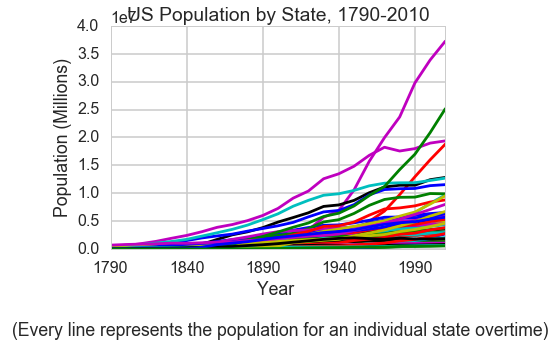

In [60]:
df.T.plot(legend=None)
plt.ylabel("Population (Millions)")
plt.xlabel('Year \n\n (Every line represents the population for an individual state overtime)')
plt.title("US Population by State, 1790-2010")

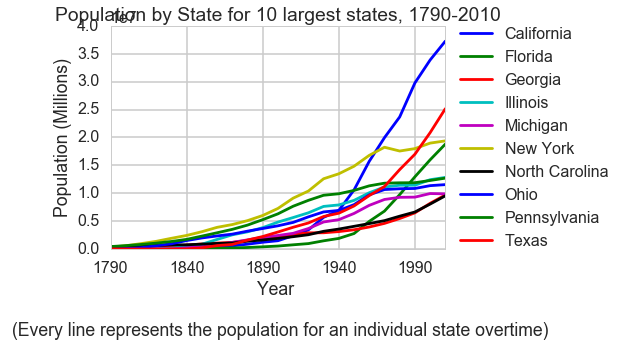

In [61]:
# let's look at just the 10 largest states (2010 population)
df.sort_values('2010', ascending=False)
largest = df['2010'].nlargest(10).index
df[df.index.isin(largest)].T.plot()
plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))
plt.title("Population by State for 10 largest states, 1790-2010")
plt.ylabel("Population (Millions)")
plt.xlabel('Year \n\n (Every line represents the population for an individual state overtime)')

Perhaps it will be more interested to view as percentage of total US population, so we can see relative change overtime…

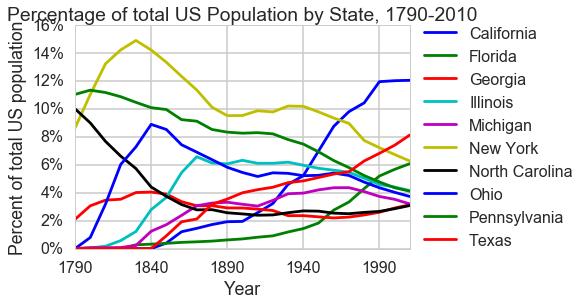

In [62]:
import matplotlib.ticker as mtick
cols = df.columns
by_percent = df[cols].div(df[cols].sum(axis=0), axis=1).multiply(100)
by_percent[by_percent.index.isin(largest)].T.plot()
plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))
plt.ylabel("Percent of total US population")
plt.xlabel("Year")
plt.title("Percentage of total US Population by State, 1790-2010")

# Make y-axis percentages 
ax = plt.gca()
fmt = '%.0f%%' # Format you want the ticks, e.g. '40%'
yticks = mtick.FormatStrFormatter(fmt)
ax.yaxis.set_major_formatter(yticks)

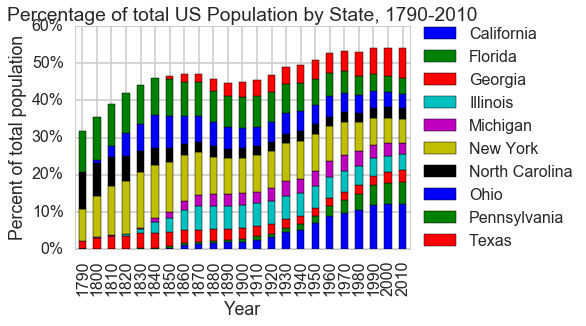

In [63]:
by_percent[by_percent.index.isin(largest)].T.plot(kind="bar",stacked=True)
plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))
plt.ylabel("Percent of total population")
plt.xlabel("Year")
plt.title("Percentage of total US Population by State, 1790-2010")

ax = plt.gca()
ax.yaxis.set_major_formatter(yticks)